

* **Protein Variant Property Analysis:**

    * **Data Generation:** Utilizes a generative AI model (LLM) to create hypothetical protein variants, including a simulated `Mutational_Effect_Score` and `Mutation_Count`. This data is then enriched with simulated experimental measurements for `Expression_Level` and `Stability_Score`, and a categorical `Immunogenicity_Prediction`.

    * **Exploratory Data Analysis (EDA):** Provides initial data snapshots, descriptive statistics, and visualizations to understand the dataset's characteristics.

    * **Visualizations:**

        * Scatter plot of `Stability_Score` versus `Mutational_Effect_Score`, colored by `Immunogenicity_Prediction` and sized by `Mutation_Count`, to explore multivariate relationships.

        * Histogram illustrating the distribution of simulated `Stability_Score` values.

    * **Machine Learning Model:** Develops a regression model using `RandomForestRegressor` to predict `Stability_Score` based on features including `Mutation_Count`, `Mutational_Effect_Score`, `Expression_Level`, and one-hot encoded `Immunogenicity_Prediction`.

    * **Model Evaluation & Interpretation:** Reports Mean Absolute Error (MAE) and R-squared (R2) for model performance, and visualizes actual vs. predicted scores and feature importances to understand which factors drive protein stability.


Author: Chandana Kodiweera, Ph.D.


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import json


In [2]:
!dir data

 Volume in drive C has no label.
 Volume Serial Number is B68D-FE18

 Directory of C:\Users\kodiw\OneDrive\Genomicx\Protein_Engineering\data

07/13/2025  12:42 PM    <DIR>          .
07/13/2025  08:15 PM    <DIR>          ..
07/13/2025  12:10 PM               282 $HHB.pdb
07/13/2025  12:43 PM            49,491 1CRN.pdb
07/13/2025  12:42 PM            78,570 1UBQ.pdb
07/13/2025  12:09 PM         2,197,935 2J58.pdb
07/13/2025  12:10 PM           473,769 4HHB.pdb
07/13/2025  12:43 PM         2,946,618 6RDE.pdb
07/12/2025  12:50 PM            35,007 protien_variants.json
               7 File(s)      5,781,672 bytes
               2 Dir(s)  572,339,392,512 bytes free


In [3]:
protien_variants = pd.read_json('data/protien_variants.json') # protien variants data were created by Gemini Flash 2.5

In [4]:
protien_variants.head()

,Mutation_Count,Mutational_Effect_Score
0,4.0,0.15
1,8.0,-0.32
2,2.0,0.48
3,6.0,-0.05
4,1.0,0.39


In [5]:
# Simulating other experimental data and calculate final Stability_Score

base_stability = 75 # Baseline stability score
protien_variants['Protein_Variant_ID'] = [f'PV_{i:04d}' for i in range(len(protien_variants))]
protien_variants['Expression_Level'] = np.random.normal(loc=100, scale=20, size=len(protien_variants))
protien_variants['Expression_Level'] = np.clip(protien_variants['Expression_Level'], 50, 150) # Clip to reasonable range

# Simulating Stability_Score based on Mutational_Effect_Score, Mutation_Count, and some noise

protien_variants['Stability_Score'] = (
    base_stability
    + (protien_variants['Mutational_Effect_Score'] * 40)  # Strong impact from LLM's score
    - (protien_variants['Mutation_Count'] * 2)             # Penalty for more mutations
    + np.random.normal(loc=0, scale=5, size=len(protien_variants)) # Random experimental noise
)
protien_variants['Stability_Score'] = np.clip(protien_variants['Stability_Score'], 50, 100) # Clip stability to a realistic range

# Simulating Immunogenicity_Prediction (categorical)
immunogenicity_categories = ['Low', 'Medium', 'High']
protien_variants['Immunogenicity_Prediction'] = np.random.choice(immunogenicity_categories, size=len(protien_variants), p=[0.6, 0.3, 0.1])


In [6]:
nan_count = protien_variants['Stability_Score'].isnull().sum()
print(nan_count)

7


In [7]:
# Exploratory Data Analysis (EDA)
print("\n--- Initial Data Snapshot (with simulated experimental results) ---")
print(protien_variants.head())
print("\n--- Data Info ---")
print(protien_variants.info())
print("\n--- Descriptive Statistics ---")
print(protien_variants.describe())


--- Initial Data Snapshot (with simulated experimental results) ---
   Mutation_Count  Mutational_Effect_Score Protein_Variant_ID  \
0             4.0                     0.15            PV_0000   
1             8.0                    -0.32            PV_0001   
2             2.0                     0.48            PV_0002   
3             6.0                    -0.05            PV_0003   
4             1.0                     0.39            PV_0004   

   Expression_Level  Stability_Score Immunogenicity_Prediction  
0         94.305625        79.058724                      High  
1        108.072662        55.140063                       Low  
2        116.878952        96.429346                    Medium  
3        105.991936        56.087340                    Medium  
4        104.593792        96.986221                       Low  

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 6 columns):
 #   Column                

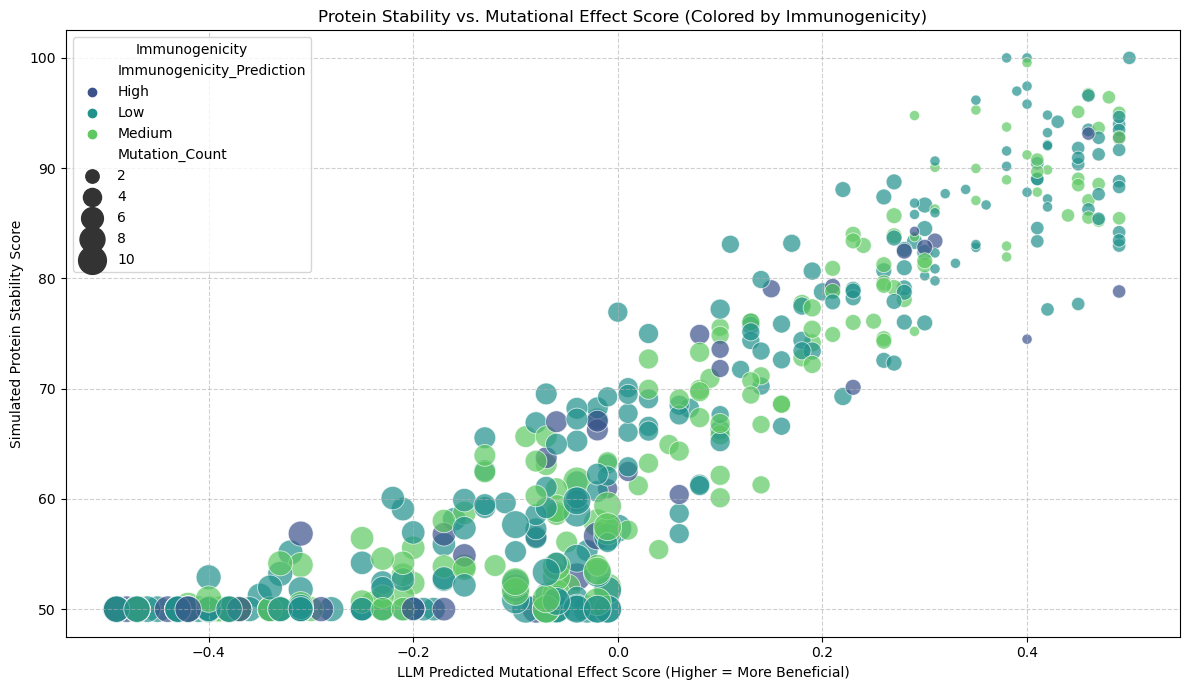

C:\Users\kodiw\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


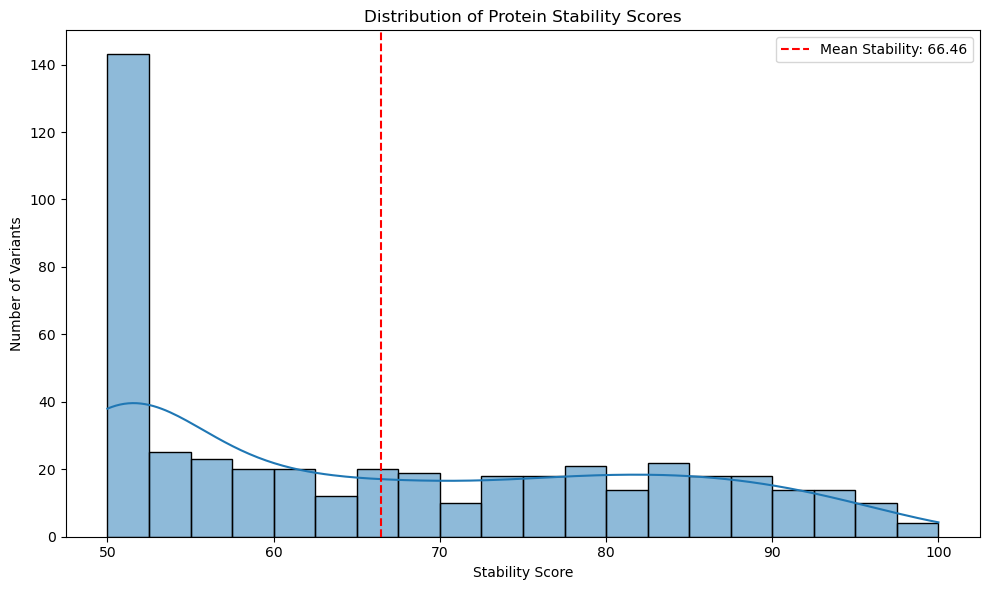

In [8]:
# Visualize the relationship between LLM's Mutational_Effect_Score and final Stability_Score
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=protien_variants,
    x='Mutational_Effect_Score',
    y='Stability_Score',
    hue='Immunogenicity_Prediction',
    size='Mutation_Count',
    sizes=(20, 400), # Size range for points
    palette='viridis',
    alpha=0.7
)
plt.title('Protein Stability vs. Mutational Effect Score (Colored by Immunogenicity)')
plt.xlabel('LLM Predicted Mutational Effect Score (Higher = More Beneficial)')
plt.ylabel('Simulated Protein Stability Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Immunogenicity')
plt.tight_layout()
plt.show()

# Visualize the distribution of Stability Scores
plt.figure(figsize=(10, 6))
sns.histplot(protien_variants['Stability_Score'], bins=20, kde=True)
plt.title('Distribution of Protein Stability Scores')
plt.xlabel('Stability Score')
plt.ylabel('Number of Variants')
plt.axvline(protien_variants['Stability_Score'].mean(), color='red', linestyle='--', label=f'Mean Stability: {protien_variants["Stability_Score"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Machine Learning Model: Predict Protein Stability

# Define features (X) and target (y)
features = ['Mutation_Count', 'Mutational_Effect_Score', 'Expression_Level', 'Immunogenicity_Prediction']
target = 'Stability_Score'

original_rows = len(protien_variants)
protien_variants_cleaned = protien_variants.dropna(subset=features + [target])
if len(protien_variants_cleaned) < original_rows:
    print(f"WARNING: Removed {original_rows - len(protien_variants_cleaned)} rows due to NaNs in features or target.")

X = protien_variants_cleaned[features].copy()
y = protien_variants_cleaned[target]



# One-hot encode the categorical 'Immunogenicity_Prediction' feature
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
immunogenicity_encoded = encoder.fit_transform(X[['Immunogenicity_Prediction']])
immunogenicity_df = pd.DataFrame(immunogenicity_encoded, columns=encoder.get_feature_names_out(['Immunogenicity_Prediction']))

# Drop original categorical column and concatenate encoded columns
X = X.drop('Immunogenicity_Prediction', axis=1)
X = pd.concat([X.reset_index(drop=True), immunogenicity_df], axis=1) # Use reset_index to align DataFrames



print("\n--- Features for ML Model (after One-Hot Encoding) ---")
print(X.head())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)



--- Features for ML Model (after One-Hot Encoding) ---
   Mutation_Count  Mutational_Effect_Score  Expression_Level  \
0             4.0                     0.15         94.305625   
1             8.0                    -0.32        108.072662   
2             2.0                     0.48        116.878952   
3             6.0                    -0.05        105.991936   
4             1.0                     0.39        104.593792   

   Immunogenicity_Prediction_High  Immunogenicity_Prediction_Low  \
0                             1.0                            0.0   
1                             0.0                            1.0   
2                             0.0                            0.0   
3                             0.0                            0.0   
4                             0.0                            1.0   

   Immunogenicity_Prediction_Medium  
0                               0.0  
1                               0.0  
2                               1.0 

In [10]:
# --- Model Evaluation ---
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- Machine Learning Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")


--- Machine Learning Model Evaluation ---
Mean Absolute Error (MAE): 3.32
R-squared (R2): 0.92


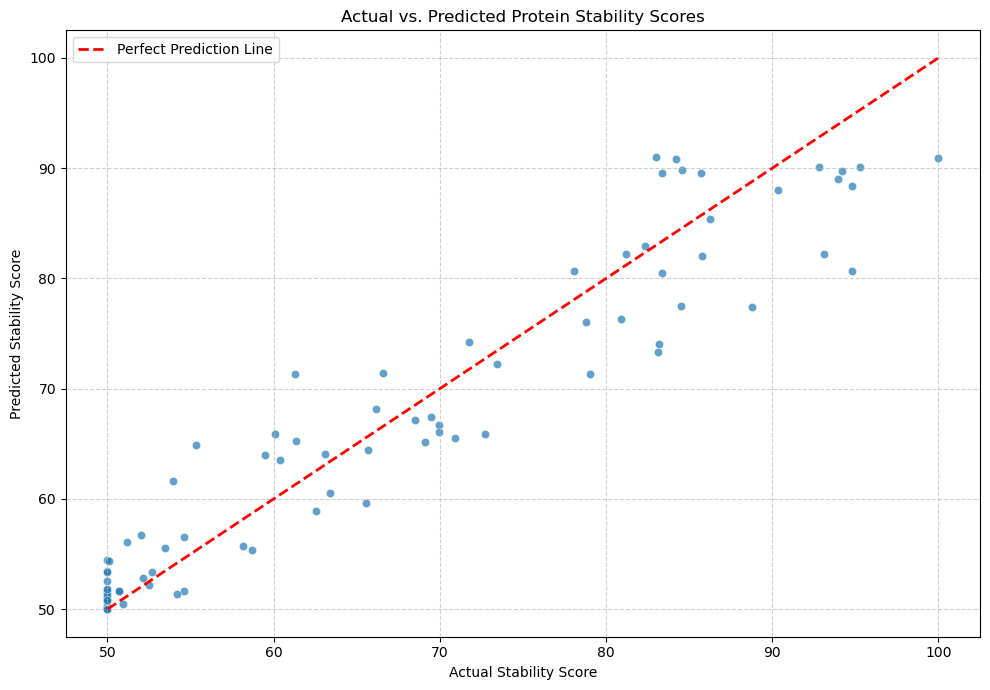

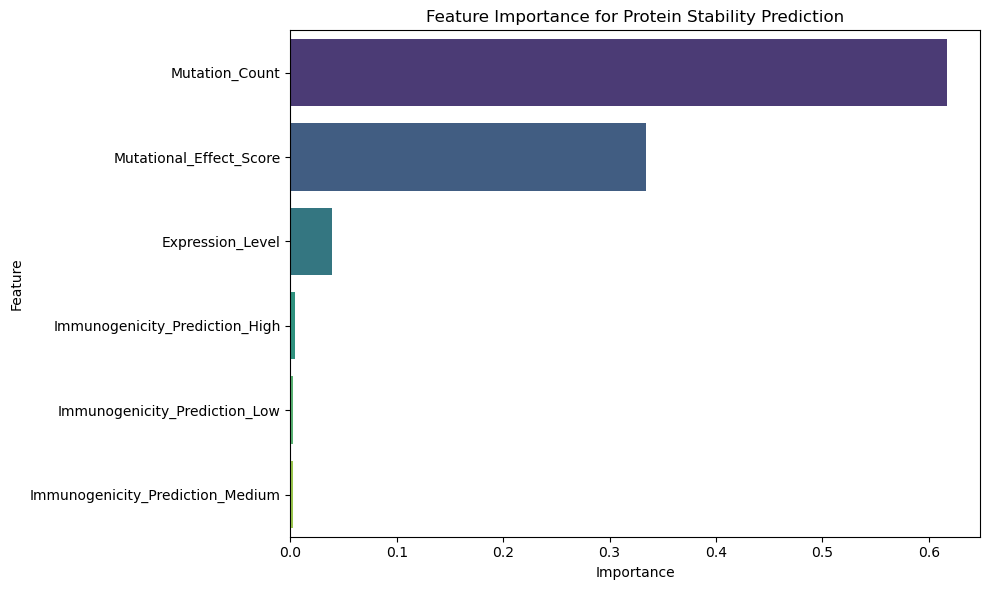


Analysis Complete
This project demonstrates data generation using generative AI, exploratory data analysis,
and a machine learning model to predict protein stability based on various features,
including a simulated LLM-predicted mutational effect score.


In [11]:
# Visualization of Model Results 

# Plot Actual vs. Predicted Stability Scores
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.title('Actual vs. Predicted Protein Stability Scores')
plt.xlabel('Actual Stability Score')
plt.ylabel('Predicted Stability Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Feature Importance Plot
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('Feature Importance for Protein Stability Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nAnalysis Complete")
print("This project demonstrates data generation using generative AI, exploratory data analysis,")
print("and a machine learning model to predict protein stability based on various features,")
print("including a simulated LLM-predicted mutational effect score.")
